In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns
data, label = make_classification(n_features=10,
                                  n_informative=10,
                                  n_redundant=0,
                                  n_repeated=0,
                                  n_classes=2,
                                  random_state=2018)
label = label.reshape((100, 1))

In [2]:
# activation func:sigmoid
def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [3]:
# loss function
def binary_crossentropy(label, pred_y):
    return np.sum(-label * np.log(pred_y) - (1 - label) * np.log(1 - pred_y))

In [4]:
epoch = 3000
cost = []
w0 = np.random.normal(size=(10, 10))
w1 = np.random.normal(size=(10, 10))
w2 = np.random.normal(size=(10, 1))
for i in range(epoch):
    l1_out = sigmoid(np.dot(data, w0))
    l2_out = sigmoid(np.dot(l1_out, w1))
    pred_y = sigmoid(np.dot(l2_out, w2))
    pred_err = (label - pred_y) * (pred_y * (1 - pred_y))
    l2_to_l1_err = pred_err.dot(w2.T) * (l2_out * (1 - l2_out))
    l1_to_input_err = l2_to_l1_err.dot(w1.T) * (l1_out * (1 - l1_out))
    w2 += l2_out.T.dot(pred_err)
    w1 += l1_out.T.dot(l2_to_l1_err)
    w0 += data.T.dot(l1_to_input_err)
    cost.append(binary_crossentropy(label, pred_y))
    print('step--->>', i, 'cost --->> ', cost[-1])    

step--->> 0 cost --->>  222.856889606
step--->> 1 cost --->>  63.5697744084
step--->> 2 cost --->>  942.964833757
step--->> 3 cost --->>  942.930112312
step--->> 4 cost --->>  942.895347556
step--->> 5 cost --->>  942.860539379
step--->> 6 cost --->>  942.825687675
step--->> 7 cost --->>  942.790792335
step--->> 8 cost --->>  942.755853251
step--->> 9 cost --->>  942.720870313
step--->> 10 cost --->>  942.685843411
step--->> 11 cost --->>  942.650772436
step--->> 12 cost --->>  942.615657278
step--->> 13 cost --->>  942.580497826
step--->> 14 cost --->>  942.545293968
step--->> 15 cost --->>  942.510045593
step--->> 16 cost --->>  942.474752589
step--->> 17 cost --->>  942.439414844
step--->> 18 cost --->>  942.404032245
step--->> 19 cost --->>  942.368604678
step--->> 20 cost --->>  942.33313203
step--->> 21 cost --->>  942.297614186
step--->> 22 cost --->>  942.262051033
step--->> 23 cost --->>  942.226442455
step--->> 24 cost --->>  942.190788337
step--->> 25 cost --->>  942.1550885

step--->> 375 cost --->>  925.581452044
step--->> 376 cost --->>  925.516808555
step--->> 377 cost --->>  925.452016153
step--->> 378 cost --->>  925.387074156
step--->> 379 cost --->>  925.321981875
step--->> 380 cost --->>  925.256738621
step--->> 381 cost --->>  925.191343697
step--->> 382 cost --->>  925.125796401
step--->> 383 cost --->>  925.060096027
step--->> 384 cost --->>  924.994241866
step--->> 385 cost --->>  924.9282332
step--->> 386 cost --->>  924.862069309
step--->> 387 cost --->>  924.795749467
step--->> 388 cost --->>  924.729272943
step--->> 389 cost --->>  924.662639002
step--->> 390 cost --->>  924.595846901
step--->> 391 cost --->>  924.528895894
step--->> 392 cost --->>  924.46178523
step--->> 393 cost --->>  924.394514152
step--->> 394 cost --->>  924.327081896
step--->> 395 cost --->>  924.259487695
step--->> 396 cost --->>  924.191730776
step--->> 397 cost --->>  924.123810359
step--->> 398 cost --->>  924.05572566
step--->> 399 cost --->>  923.987475889
step

step--->> 946 cost --->>  0.429439523569
step--->> 947 cost --->>  0.426888501472
step--->> 948 cost --->>  0.424371000828
step--->> 949 cost --->>  0.421886250806
step--->> 950 cost --->>  0.419433500976
step--->> 951 cost --->>  0.417012020462
step--->> 952 cost --->>  0.414621097143
step--->> 953 cost --->>  0.412260036905
step--->> 954 cost --->>  0.409928162921
step--->> 955 cost --->>  0.407624814987
step--->> 956 cost --->>  0.405349348887
step--->> 957 cost --->>  0.403101135804
step--->> 958 cost --->>  0.400879561764
step--->> 959 cost --->>  0.398684027118
step--->> 960 cost --->>  0.396513946068
step--->> 961 cost --->>  0.394368746224
step--->> 962 cost --->>  0.392247868196
step--->> 963 cost --->>  0.390150765228
step--->> 964 cost --->>  0.388076902872
step--->> 965 cost --->>  0.386025758691
step--->> 966 cost --->>  0.383996822007
step--->> 967 cost --->>  0.381989593686
step--->> 968 cost --->>  0.380003585968
step--->> 969 cost --->>  0.378038322324
step--->> 970 co

step--->> 1548 cost --->>  0.141433333123
step--->> 1549 cost --->>  0.14134118261
step--->> 1550 cost --->>  0.141249231316
step--->> 1551 cost --->>  0.141157478495
step--->> 1552 cost --->>  0.141065923406
step--->> 1553 cost --->>  0.140974565308
step--->> 1554 cost --->>  0.140883403469
step--->> 1555 cost --->>  0.140792437157
step--->> 1556 cost --->>  0.140701665647
step--->> 1557 cost --->>  0.140611088215
step--->> 1558 cost --->>  0.140520704142
step--->> 1559 cost --->>  0.140430512714
step--->> 1560 cost --->>  0.140340513219
step--->> 1561 cost --->>  0.14025070495
step--->> 1562 cost --->>  0.140161087203
step--->> 1563 cost --->>  0.140071659278
step--->> 1564 cost --->>  0.139982420479
step--->> 1565 cost --->>  0.139893370113
step--->> 1566 cost --->>  0.139804507491
step--->> 1567 cost --->>  0.139715831927
step--->> 1568 cost --->>  0.139627342741
step--->> 1569 cost --->>  0.139539039253
step--->> 1570 cost --->>  0.13945092079
step--->> 1571 cost --->>  0.13936298

step--->> 2166 cost --->>  0.106292665473
step--->> 2167 cost --->>  0.106256472101
step--->> 2168 cost --->>  0.106220318484
step--->> 2169 cost --->>  0.106184204546
step--->> 2170 cost --->>  0.106148130214
step--->> 2171 cost --->>  0.106112095411
step--->> 2172 cost --->>  0.106076100065
step--->> 2173 cost --->>  0.1060401441
step--->> 2174 cost --->>  0.106004227443
step--->> 2175 cost --->>  0.10596835002
step--->> 2176 cost --->>  0.105932511757
step--->> 2177 cost --->>  0.105896712581
step--->> 2178 cost --->>  0.10586095242
step--->> 2179 cost --->>  0.105825231199
step--->> 2180 cost --->>  0.105789548846
step--->> 2181 cost --->>  0.105753905289
step--->> 2182 cost --->>  0.105718300454
step--->> 2183 cost --->>  0.105682734271
step--->> 2184 cost --->>  0.105647206666
step--->> 2185 cost --->>  0.105611717568
step--->> 2186 cost --->>  0.105576266905
step--->> 2187 cost --->>  0.105540854607
step--->> 2188 cost --->>  0.105505480601
step--->> 2189 cost --->>  0.105470144

step--->> 2786 cost --->>  0.0893777066848
step--->> 2787 cost --->>  0.0893569334922
step--->> 2788 cost --->>  0.0893361756522
step--->> 2789 cost --->>  0.0893154331456
step--->> 2790 cost --->>  0.0892947059528
step--->> 2791 cost --->>  0.0892739940547
step--->> 2792 cost --->>  0.0892532974318
step--->> 2793 cost --->>  0.089232616065
step--->> 2794 cost --->>  0.0892119499349
step--->> 2795 cost --->>  0.0891912990225
step--->> 2796 cost --->>  0.0891706633085
step--->> 2797 cost --->>  0.0891500427739
step--->> 2798 cost --->>  0.0891294373994
step--->> 2799 cost --->>  0.0891088471661
step--->> 2800 cost --->>  0.089088272055
step--->> 2801 cost --->>  0.089067712047
step--->> 2802 cost --->>  0.0890471671233
step--->> 2803 cost --->>  0.0890266372648
step--->> 2804 cost --->>  0.0890061224527
step--->> 2805 cost --->>  0.0889856226681
step--->> 2806 cost --->>  0.0889651378923
step--->> 2807 cost --->>  0.0889446681064
step--->> 2808 cost --->>  0.0889242132916
step--->> 2809

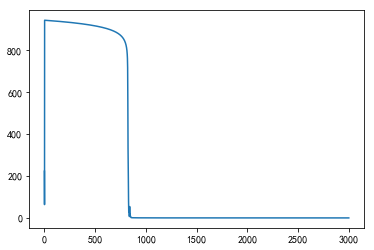

In [5]:
# loss曲线
plt.plot(list(range(len(cost))), cost)
plt.show()

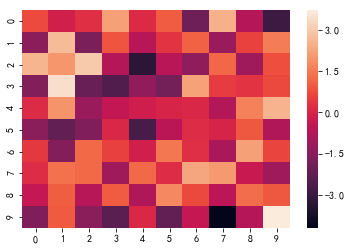

In [6]:
# w0权重
sns.heatmap(w0)
plt.show()

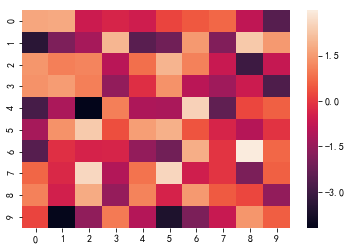

In [7]:
# w1 权重
sns.heatmap(w1)
plt.show()

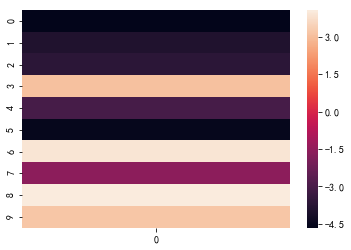

In [8]:
# w2权重
sns.heatmap(w2)
plt.show()